# Visualizing WhatsApp Chats

### Importing Modules:
* re - for using regex expressions
* pandas - for exploiting dataframes
* matplotlib - for visualization (inline for ploting dataframes)

In [1]:
import re
import pandas as pd
%matplotlib inline

#### Exported chats
Export WhatsApp chats as follows:
* Navigate to contact/group you want to export chat of
* Tap on the menu (3dots in the right corner)
* Tap on more and then tap on Export chat
* Choose WITHOUT MEDIA from the prompt
* Wait for a moment on the Initializing screen
* Share through mail or any other means
* Gather the exported text file

The text file should have a name as: WhatsApp Chat with ... .txt. Use the same below in the filename variable

In [2]:
filename = 'Exported Chat.txt'
file = open(filename, 'r', encoding="utf8")

In [3]:
raw_data = file.read().splitlines()
# print(raw_data)

#### Regex
Regex for catching the header expression:

12/14/18, 1:28 PM - Alice: Hello!

(date), (12-hour-time) - (sender-name): (Message)

In [4]:
header_regex = re.compile(r'(\d+\/\d+\/\d+)(,)(\s)(\d+:\d+)(\s)(\w+)(\s)(-)(\s[^:]+)*(:)(\s)')

Breaking the captured regex, throughout the file and storing it in a dictionary

In [5]:
data_dict = {'id': [], 'date': [], 'time': [], 'sender': [], 'msg': []}

i = 0
for m in raw_data:
    mo = header_regex.search(m[:50])
    if mo != None:
        data_dict['id'].append(i)
        i += 1
        date = mo.group(1)
        time = mo.group(4) + mo.group(5) + mo.group(6)
        sender = mo.group(9)[1:]
        msg = m[len(mo.group(0)):]
        data_dict['date'].append(date)
        data_dict['time'].append(time)
        data_dict['sender'].append(sender)
        data_dict['msg'].append(msg)
    else:
        if(len(data_dict['msg']) != 0):
            data_dict['msg'][-1] += m
            
# print(data_dict)

Converting the dictionary into the main Pandas DataFrame

In [6]:
df = pd.DataFrame(data=data_dict)
# df

## Sender List

In [7]:
senders = []
for s in df['sender']:
    if s not in senders:
        senders.append(s)
print(senders)

['Person 5', 'Person 3', 'Person 1', 'Person 4', 'Person 6', 'Person 2', 'Person 8', 'Person 7']


## Sender Message Count

In [8]:
sender_msg_count = df['sender'].value_counts()
print(sender_msg_count)

Person 1    3139
Person 2    3128
Person 3    2228
Person 4    1658
Person 5     762
Person 6     688
Person 7     359
Person 8      39
Name: sender, dtype: int64


## Bar Chart showing messages sent by each sender

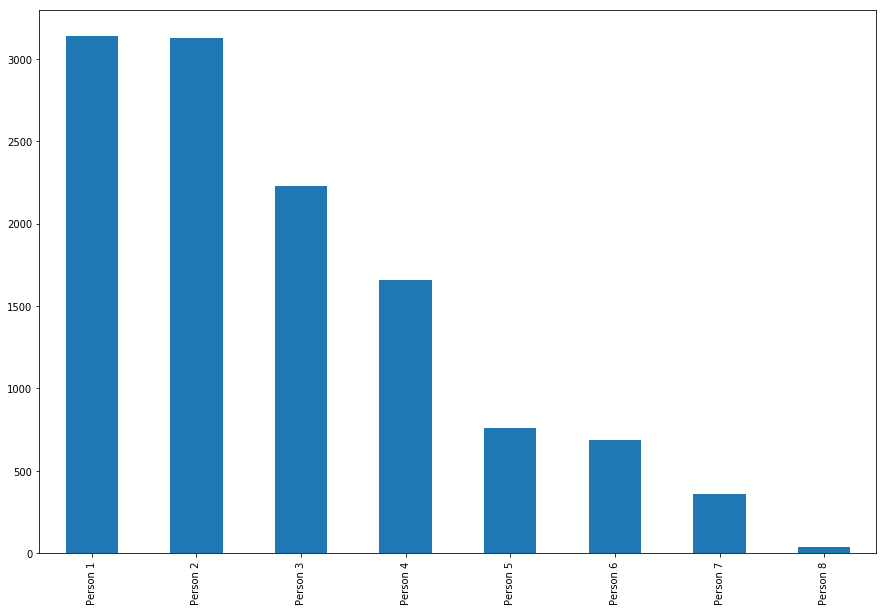

In [9]:
sender_msg_count.plot(kind = 'bar', figsize = (15, 10))

## Pie Chart showing messages sent by each sender

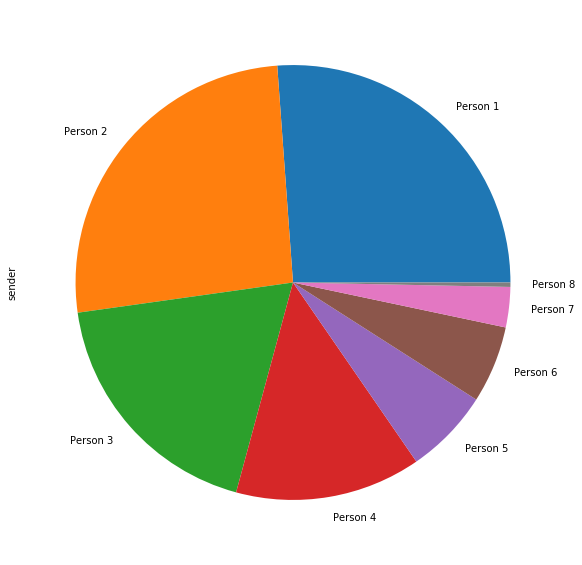

In [10]:
sender_msg_count.plot(kind = 'pie', figsize = (10, 10))

Calculating the total number of messages datewise, storing it in another Pandas DataFrame

In [11]:
dates = []
for d in df['date'].unique():
    dates.append(d)
# print(dates)

msgs = []
for d in dates:
    c = 0
    for f in df['date']:
        if d == f:
            c += 1
    msgs.append(c)
# print(msgs)

temp_dict = {'date': dates, 'msg': msgs}
# print(temp_dict)

datewise_msg_count = pd.DataFrame(data=temp_dict)
# datewise_msg_count

## Area Chart showing the total number of messages sent by dates
Days with zero messages are ommited

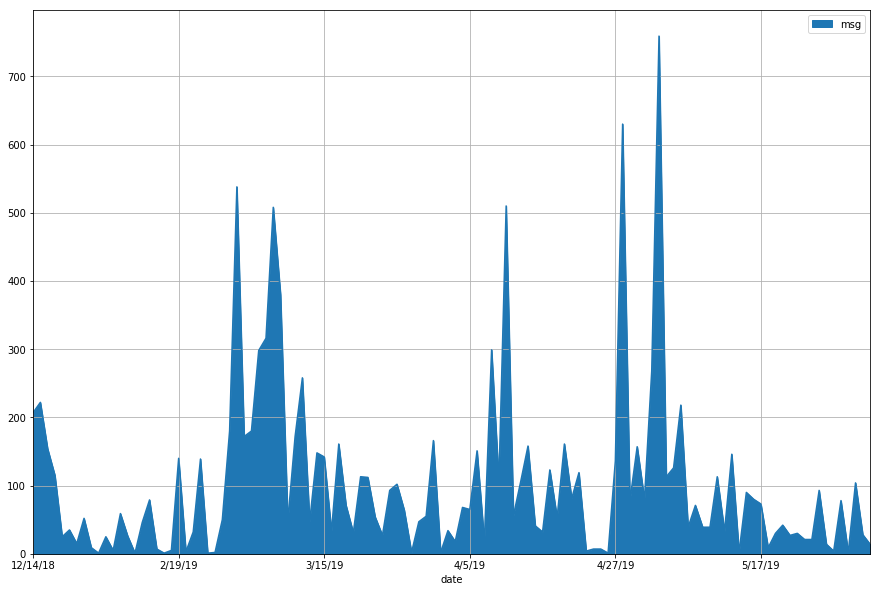

In [12]:
datewise_msg_count.plot(x = 'date', kind = 'area', figsize = (15, 10), grid = True)

## Date on which maximum number of messages were sent

In [13]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmax()]

date    5/3/19
msg        759
Name: 86, dtype: object

## Date on which minimum number of messages were sent
Days with zero messages are ommited

In [14]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmin()]

date    1/16/19
msg           1
Name: 9, dtype: object

Calculating total number of messages sent by each sender on all the dates (senders with zero message in a day are included too)

In [15]:
temp_dict_2 = {'date': dates}
for s in senders:
    temp_dict_2[s] = []

for s in senders:
    for d in dates:
        date_filter = df['date'] == d
        sender_filter = df['sender'] == s
        c = df['msg'][date_filter & sender_filter].count()
        temp_dict_2[s].append(c)
        
# print(temp_dict_2)
senderwise_datewise_msg_count = pd.DataFrame(data=temp_dict_2)
# senderwise_datewise_msg_count

## Line Chart showing messaging frequency of each sender, datewise

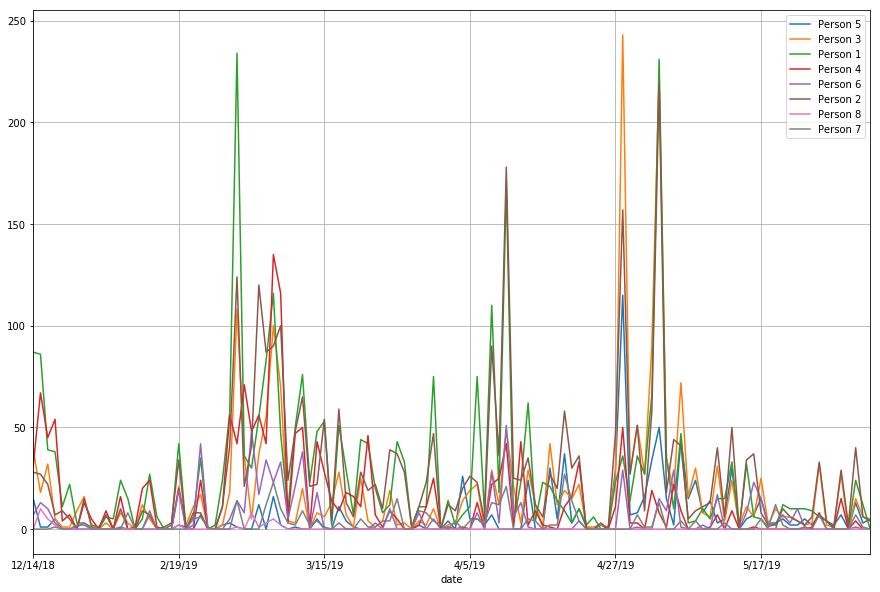

In [16]:
senderwise_datewise_msg_count.plot(x='date', kind = 'line', figsize = (15, 10), grid = True)

Grouping time by 1 hour intervals throughout the day, over all dates

In [17]:
times = []
time_regex = re.compile(r'(\d+):(\d+)(\s)(\w+)')
for t in df['time']:
    mo = time_regex.search(t)
    if mo.group(4) == 'PM' and mo.group(1) == '12':
        times.append(12)
    elif mo.group(4) == 'PM':
        times.append(int(mo.group(1)) + 12)
    elif mo.group(4) == 'AM' and mo.group(1) == '12':
        times.append(0)
    else:
        times.append(int(mo.group(1)))
        
time_dict = {'time': times, 'msg': list(df['msg'])}
time_df = pd.DataFrame(data=time_dict)
# print(time_df)

time_count_dict = {'hour': [], 'msg': []}
for i in range(0, 24):
    match = (str(i) + ':')
    time_filter = time_df['time'] == i
    time_count_dict['hour'].append(i)
    time_count_dict['msg'].append(time_df['msg'][time_filter].count())

# print(time_count_dict)

time_count_df = pd.DataFrame(data=time_count_dict)
# time_count_df

## Bar Chart showing hourly messaging frequency

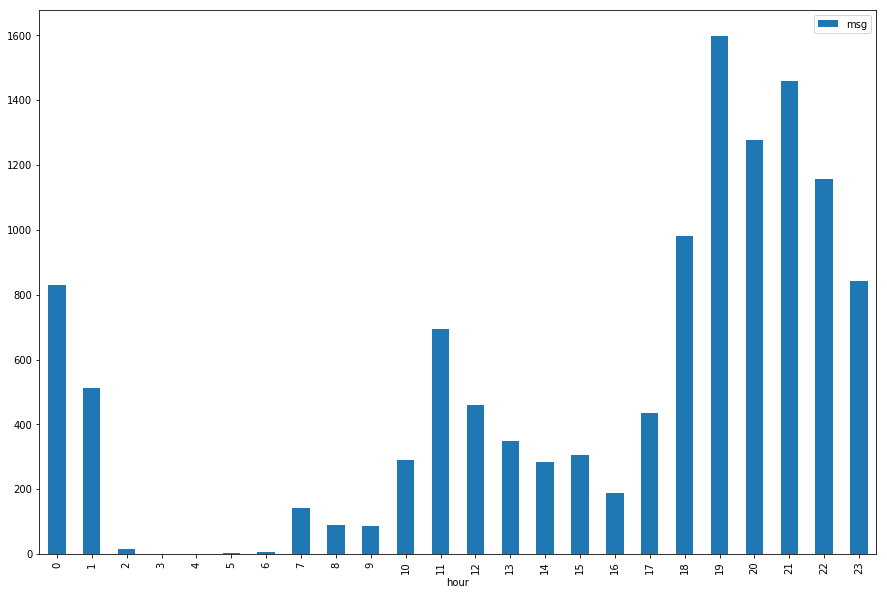

In [18]:
time_count_df.plot(x = 'hour', kind = 'bar', figsize = (15, 10))